In [1]:
import numpy as np
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

In [2]:
%matplotlib inline

from qiskit import *
from qiskit.visualization import *
from qiskit.tools.monitor import *

import numpy as np

def init_grover(q):

    circ = QuantumCircuit(q) 

    n = len(q)
    
    circ.x(n-1) # The qubit that receives the oracle output must be set to |1>
    for i in range(n):
        circ.h(q[i])
    
    circ.barrier()
    
    return circ

In [3]:
def difussion(q):
    
    circ = QuantumCircuit(q) 
    
    # Diffusion operator
    
    n = len(q)
    
    for i in range(n-1):
        circ.h(q[i])
        
    for i in range(n-1):
        circ.x(q[i])
        
    # To implement a multicontrolled Z we use a multicontrolled Z rotation
    
    mcz = QuantumCircuit(q, name = 'cZ')
    if(n>2):
        mcz.mcrz(np.pi,q[0:n-2],q[n-2])
    else:
        mcz.z(q[0]) # If there is only input qubit for the oracle, we don't have controls 
    
    circ.append(mcz.to_instruction(),q)
    
    for i in range(n-1):
        circ.x(q[i])

    for i in range(n-1):
        circ.h(q[i])

    circ.barrier()
    
    return circ

In [4]:
def ones(q):

    # We will use a multicontrolled X gate 
    
    circ = QuantumCircuit(q)
    
    n = len(q)
    
    circ.mcx(q[0:n-1],q[n-1])
    
    return circ

In [5]:
def grover(n, oracle, it = 10, measurement = True):
    
    q = QuantumRegister(n, name = 'q') # We create the quantum register
    if(measurement):
        c = ClassicalRegister(n-1,name='c') # We are only going to measure the qubits that are the input to the oracle
        circ = QuantumCircuit(q,c) # We create the circuit
    else:
        circ = QuantumCircuit(q) # Circuit without measurements
    
    circ += init_grover(q) # We add the initial part
    
    for _ in range(it): # We add it repetitions of the oracle plus the diffusion operator
        circ += oracle(q)
        circ += difussion(q)
        
    if(measurement):  # Measurements
        circ.measure(q[0:n-1],c)
            
        
    return circ

<ipython-input-5-3acb20f375b5>:10: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  circ += init_grover(q) # We add the initial part
/opt/conda/lib/python3.8/site-packages/qiskit/circuit/quantumcircuit.py:876: DeprecationWarning: The QuantumCircuit.extend() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  return self.extend(rhs)


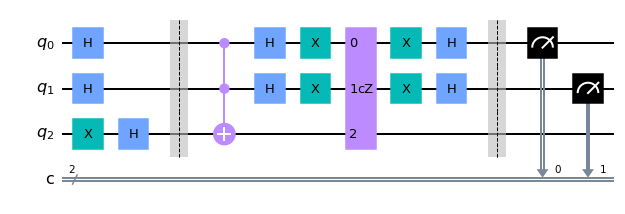

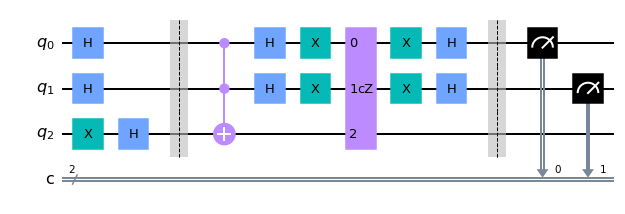

In [6]:
n = 3

circ_grover = grover(n,ones,1)
circ_grover.draw(output = 'mpl')

In [7]:
backend = Aer.get_backend('qasm_simulator')
job = execute(circ_grover, backend)
counts = job.result().get_counts()
print(counts)

{'11': 1024}


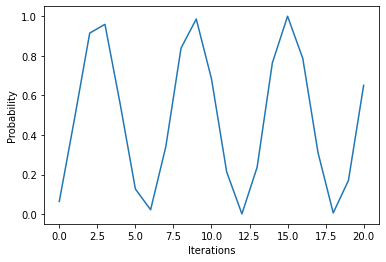

In [9]:
import matplotlib.pyplot as plt

n = 5
max_it = 20
shots = 1000
backend = Aer.get_backend('qasm_simulator')
target=(n-1)*'1' # The marked element as a string, to retrieve its probability

prob = [0.0 for _ in range(max_it+1)]

for it in range(max_it+1):
    circ_grover2 = grover(n,ones,it)
    job = execute(circ_grover2, backend, shots = shots)
    counts = job.result().get_counts()
    if target in counts.keys():
        prob[it]=counts[target]/shots 
    else:
        prob[it] = 0 # Element not found
       
iter = range(max_it+1)
plt.xlabel('Iterations')
plt.ylabel('Probability')
plt.plot(iter,prob)
plt.show()
        